# Pneumonia Detection

The dataset used in this notebook can be found here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## Data Preprocessing

First all the necessary libraries will be imported.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score 
import time
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import torchvision

The random seeds will be set.

In [2]:
np.random.seed(42)
torch.manual_seed(42)

The files in the validation folder were added to the training folder. Since there were only 16 images in the validation folder it might be a better idea to create a larger validation set from the training set. It should be noted that a similar method could be used to split the test set instead.

In [3]:
print(os.listdir("chest_xray/"))

['test', 'train']


In [4]:
data_dir = "chest_xray/"
TRAIN = "train"
TEST = "test"
batch_size = 128

In [5]:
normal_dir = data_dir + TRAIN + "/NORMAL/"
pnuemonia_directory = data_dir + TRAIN + "/PNEUMONIA/"
n_list = len(os.listdir(normal_dir))
p_list = len(os.listdir(pnuemonia_directory))
total_cases = n_list+p_list
print("Number of normal cases: " + str(n_list))
print("Number of pnuemonia cases: " + str(p_list))
print("Total number of data points in the trainind data set: " + str(total_cases))

Number of normal cases: 1349
Number of pnuemonia cases: 3883
Total number of data points in the trainind data set: 5232


The following function will be used to preprocess the data.

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

SubsetRandomSampler will be used to split the training set. First, the indices of the images from the training set will be shuffled and split into the train_indices and valid_indices variables. The validation_split variable specifies the percentage of the images in the train folder that will be in the final training set. 

In [7]:
# Define the image folder for each of the data set types
trainset = torchvision.datasets.ImageFolder(
    root=data_dir + TRAIN,
    transform=transform
)
testset = torchvision.datasets.ImageFolder(
    root=data_dir  + TEST,
    transform=transform
)


validation_split = 0.9
indices = list(range(total_cases))
split = int(np.floor(validation_split * total_cases))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, valid_indices = indices[:split], indices[split:] 
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_indices)

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
test_dataloader = torch.utils.data.DataLoader(testset, shuffle=False)

## Model training and evaluation

Transfer learning will be used to train the VGG16 model on the new data set (the weights of the convolutional layer will be frozen however the final layer of the VGG16 model needs to be changed.)

In [3]:
# It may take a few seconds to load the vgg_model
vgg_model = models.vgg16(pretrained=True)

In [16]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# The weights of the convolutional layers will now be frozen.
for param in vgg_model.features.parameters():
    param.requires_grad = False

In [18]:
# The final fully connected layer will be replaced.
n_inputs = vgg_model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 2)
vgg_model.classifier[6] = last_layer
print(vgg_model.classifier[6].out_features)

2


In [19]:
train_dataloader

Since the dataset is imbalanced, the f1 score may be a better metric for model evaluation.

In [20]:
# Now the model will be trained for 5 epochs.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr = 0.0001)
epochs = 5 
running_loss_history = []
running_corrects_history = []
runnning_f1_history = []
val_running_loss_history = []
val_running_corrects_history = []
val_running_f1_history = []

for e in range(epochs):
    start_time = time.time()
    running_loss = 0.0
    running_corrects = 0.0
    target_true = 0.0
    predicted_true = 0.0
    correct_true = 0.0
    epoch_f1 = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    val_target_true = 0.0
    val_predicted_true = 0.0
    val_correct_true = 0.0
    val_running_f1 = 0.0
    for inputs, labels in train_dataloader:
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        target_true += torch.sum(labels == 1).float()
        predicted_true += torch.sum(preds == 1).float()
        correct_true += torch.sum((labels == 1) * (preds == 1)).float()
    else:
        with torch.no_grad():
            for val_inputs, val_labels in valid_dataloader:
                val_outputs = vgg_model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_target_true += torch.sum(val_labels == 1).float()
                val_predicted_true += torch.sum(val_preds == 1).float()
                val_correct_true += torch.sum((val_labels == 1) * (val_preds == 1)).float()
        
        epoch_loss = running_loss/len(train_indices)
        epoch_acc = running_corrects.float()/ len(train_indices)
        recall = correct_true / target_true
        precision = correct_true / predicted_true
        epoch_f1 = 2 * precision * recall / (precision + recall)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        runnning_f1_history.append(epoch_f1)
        
        val_epoch_loss = val_running_loss/len(valid_indices)
        val_epoch_acc = val_running_corrects.float()/ len(valid_indices)
        val_recall = val_correct_true / val_target_true
        val_precision = val_correct_true / val_predicted_true
        val_running_f1 = 2 * val_precision * val_recall / (val_precision + val_recall)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        val_running_f1_history.append(val_running_f1)
        
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f}, f1 score {:.4f}'.format(epoch_loss, epoch_acc.item(), epoch_f1.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}, f1 score {:.4f}'.format(val_epoch_loss, val_epoch_acc.item(), val_running_f1.item()))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed time: " + str(elapsed_time) + " seconds")

epoch : 1
training loss: 0.0014, acc 0.9233, f1 score 0.9482
validation loss: 0.0009, validation acc 0.9618, f1 score 0.9752
Elapsed time: 3320.880098104477 seconds
epoch : 2
training loss: 0.0005, acc 0.9800, f1 score 0.9865
validation loss: 0.0009, validation acc 0.9656, f1 score 0.9777
Elapsed time: 3358.5404658317566 seconds
epoch : 3
training loss: 0.0003, acc 0.9853, f1 score 0.9901
validation loss: 0.0007, validation acc 0.9695, f1 score 0.9801
Elapsed time: 3378.9637293815613 seconds
epoch : 4
training loss: 0.0002, acc 0.9917, f1 score 0.9944
validation loss: 0.0007, validation acc 0.9771, f1 score 0.9849
Elapsed time: 3372.2358903884888 seconds
epoch : 5
training loss: 0.0001, acc 0.9953, f1 score 0.9968
validation loss: 0.0011, validation acc 0.9695, f1 score 0.9800
Elapsed time: 3381.3578934669495 seconds


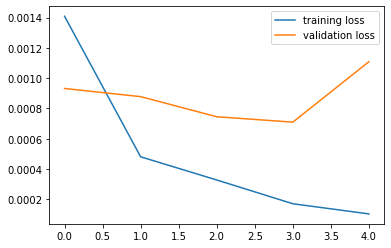

In [21]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

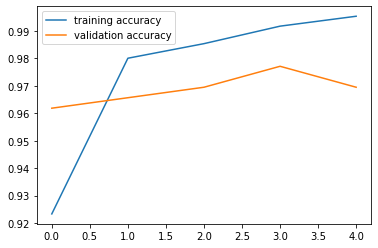

In [22]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

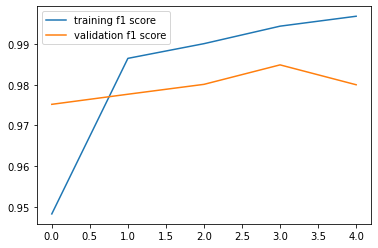

In [23]:
plt.plot(runnning_f1_history, label='training f1 score')
plt.plot(val_running_f1_history, label='validation f1 score')
plt.legend()

The model appears to overfit the dataset after 4 epochs however the model still performs well on the validation set (the validation accuracy is still 96.95% and the f1 score is 0.9800.)

In [36]:
# The model can now be saved
torch.save(vgg_model, "vgg1.pth")

Now an unbiased estimate of the accuracy and f1 score on new data can be calculated using the test set.

In [56]:
start_time = time.time()
test_loss = 0.0
test_corrects = 0.0
test_target_true = 0.0
test_predicted_true = 0.0
test_correct_true = 0.0
test_f1 = 0.0
for test_inputs, test_labels in test_dataloader:
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_labels)
    
    _, test_preds = torch.max(test_outputs, 1)
    test_corrects += torch.sum(test_preds == test_labels.data)
    test_target_true += torch.sum(test_labels == 1).float()
    test_predicted_true += torch.sum(test_preds == 1).float()
    test_correct_true += torch.sum((test_labels == 1) * (test_preds == 1)).float()

test_loss = test_loss/len(testset)
test_acc = test_corrects/ len(testset)
test_recall = test_correct_true / test_target_true
test_precision = test_correct_true / test_predicted_true
test_f1 = 2 * test_precision * test_recall / (test_precision + test_recall)
print('test loss: {:.4f}, test acc {:.4f}, f1 score {:.4f}'.format(test_loss, test_acc, test_f1))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: " + str(elapsed_time) + " seconds")

test loss: 0.0000, test acc 0.7692, f1 score 0.8435
Elapsed time: 392.14331674575806 seconds


An unbiased estimation of accuracy on new data is 76.92% and an unbiased estimation of the f1 score is 0.8435.